importing libraries

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

Read data into dataframe

In [5]:
file_path = r"synthetic_network_traffic.csv"
df = pd.read_csv(file_path)

In [6]:
df.head()

,SourceIP,DestinationIP,SourcePort,DestinationPort,Protocol,BytesSent,BytesReceived,PacketsSent,PacketsReceived,Duration,IsAnomaly
0,0.496714,-0.138264,0.647689,1.523030,-0.234153,-0.234137,1.579213,0.767435,-0.469474,0.542560,0
1,-0.463418,-0.465730,0.241962,-1.913280,-1.724918,-0.562288,-1.012831,0.314247,-0.908024,-1.412304,0
2,1.465649,-0.225776,0.067528,-1.424748,-0.544383,0.110923,-1.150994,0.375698,-0.600639,-0.291694,0
3,-0.601707,1.852278,-0.013497,-1.057711,0.822545,-1.220844,0.208864,-1.959670,-1.328186,0.196861,0
4,0.738467,0.171368,-0.115648,-0.301104,-1.478522,-0.719844,-0.460639,1.057122,0.343618,-1.763040,0


In [7]:
df.tail()

,SourceIP,DestinationIP,SourcePort,DestinationPort,Protocol,BytesSent,BytesReceived,PacketsSent,PacketsReceived,Duration,IsAnomaly
999995,0.002725,-0.638022,0.840857,1.306959,-0.992010,-0.210795,0.226693,0.948210,0.815519,0.240544,0
999996,-0.830555,-0.545716,-1.130178,0.021732,-0.565860,1.438171,0.621305,-1.768177,1.461799,-0.668388,0
999997,0.047510,-1.310967,0.173328,-1.367077,1.003435,-0.202177,-0.112733,-0.206338,0.086761,-1.954908,0
999998,-0.242768,-0.893310,-0.197664,-1.316390,-0.047899,-0.161381,-0.682240,-0.011741,0.684703,-0.019483,0
999999,0.702928,-0.506723,-0.927974,-0.190821,-0.037183,0.626149,-0.585013,1.466957,0.644408,0.923612,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 11 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   SourceIP         1000000 non-null  float64
 1   DestinationIP    1000000 non-null  float64
 2   SourcePort       1000000 non-null  float64
 3   DestinationPort  1000000 non-null  float64
 4   Protocol         1000000 non-null  float64
 5   BytesSent        1000000 non-null  float64
 6   BytesReceived    1000000 non-null  float64
 7   PacketsSent      1000000 non-null  float64
 8   PacketsReceived  1000000 non-null  float64
 9   Duration         1000000 non-null  float64
 10  IsAnomaly        1000000 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 83.9 MB


Check the total number of null values in the dataframe

In [9]:
df.isnull().sum()

SourceIP           0
DestinationIP      0
SourcePort         0
DestinationPort    0
Protocol           0
BytesSent          0
BytesReceived      0
PacketsSent        0
PacketsReceived    0
Duration           0
IsAnomaly          0
dtype: int64

Checking the values of each column

In [10]:
df.SourceIP.unique()

array([ 0.49671415, -0.46341769,  1.46564877, ...,  0.04751041,
       -0.24276814,  0.70292766])

In [11]:
df.DestinationIP.unique()

array([-0.1382643 , -0.46572975, -0.2257763 , ..., -1.31096725,
       -0.89330971, -0.50672272])

In [12]:
df.DestinationPort.unique()

array([ 1.52302986, -1.91328024, -1.42474819, ..., -1.36707748,
       -1.3163897 , -0.19082058])

In [13]:
df.Protocol.unique()

array([-0.23415337, -1.72491783, -0.54438272, ...,  1.00343528,
       -0.04789898, -0.03718258])

In [14]:
df.BytesSent.unique()

array([-0.23413696, -0.56228753,  0.11092259, ..., -0.20217726,
       -0.16138134,  0.62614888])

In [15]:
df.BytesReceived.unique()

array([ 1.57921282, -1.01283112, -1.15099358, ..., -0.11273257,
       -0.6822395 , -0.58501315])

In [16]:
df.PacketsSent.unique()

array([ 0.76743473,  0.31424733,  0.37569802, ..., -0.20633798,
       -0.01174112,  1.4669566 ])

In [17]:
df.PacketsReceived.unique()

array([-0.46947439, -0.90802408, -0.60063869, ...,  0.08676137,
        0.68470348,  0.64440822])

In [18]:
df.Duration.unique()

array([ 0.54256004, -1.4123037 , -0.29169375, ..., -1.95490755,
       -0.01948301,  0.92361196])

In [19]:
df.IsAnomaly.unique()

array([0, 1], dtype=int64)

In [20]:
df["PacketsSent"].describe()

count    1000000.000000
mean           0.000153
std            0.999976
min           -4.564944
25%           -0.674591
50%            0.000994
75%            0.675133
max            4.827623
Name: PacketsSent, dtype: float64

In [21]:
df["PacketsReceived"].describe()

count    1000000.000000
mean           0.001019
std            0.999260
min           -5.195261
25%           -0.673667
50%            0.001513
75%            0.675576
max            4.795172
Name: PacketsReceived, dtype: float64

In [22]:
df.isna().any()

SourceIP           False
DestinationIP      False
SourcePort         False
DestinationPort    False
Protocol           False
BytesSent          False
BytesReceived      False
PacketsSent        False
PacketsReceived    False
Duration           False
IsAnomaly          False
dtype: bool

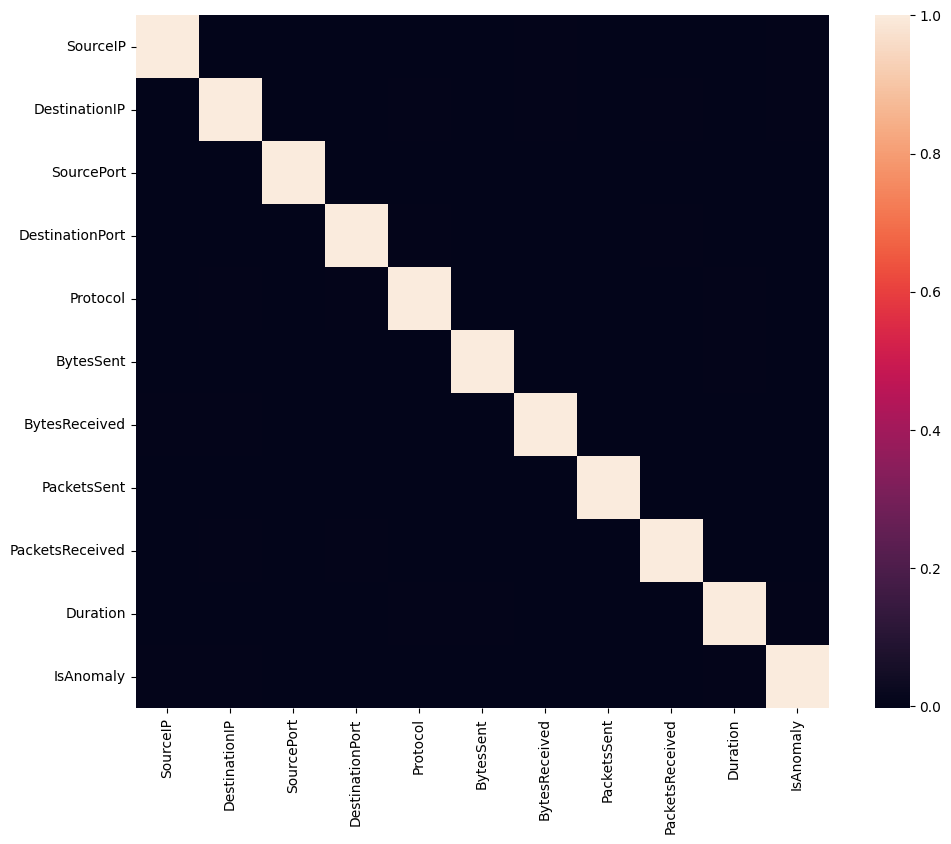

In [23]:
# I just want to check the correlation between each column, to understand what features are corelated
import seaborn as sns
correlation_matrix = df.corr()
fig = plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix,vmax=1.0,square = True)
plt.show()

In [24]:
# Feature Engineering: Generate additional features (you can customize this)
df['TotalBytes'] = df['BytesSent'] + df['BytesReceived']
df['TotalPackets'] = df['PacketsSent'] + df['PacketsReceived']

In [25]:
# Oversample the 'Anomaly' class to balance the class distribution
anomaly_data = df[df['IsAnomaly'] == 1]
oversampled_data = pd.concat([df, anomaly_data], axis=0)

In [26]:
outlier_fraction = np.ceil(len(anomaly_data)/float(len(oversampled_data)))

#Let's print how many more outliers are there in the dataset compared to normal data
print(outlier_fraction)

1.0


In [27]:
# Split the dataset into features and labels
X = oversampled_data.drop(columns=['IsAnomaly'])  # Features
y = oversampled_data['IsAnomaly']  # Labels

In [28]:
# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [29]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [30]:
# Define a random state 
state = np.random.RandomState(42)
#Let's initalize some classifiers
classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X_train), 
                                       contamination=outlier_fraction,random_state=state, verbose=1),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=0.03),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1 )
   
}

In [ ]:
n_outliers = len(anomaly_data)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        continue
        y_pred = clf.fit_predict(X_train)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X_train)
        y_pred = clf.predict(X_train)
    else:    
        continue
        clf.fit(X_train)
        scores_prediction = clf.decision_function(X_train)
        y_pred = clf.predict(X_train)
        
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y_train).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y_train,y_pred))
    print("Classification Report :")
    print(classification_report(Y_train,y_pred))

In [ ]:
n_outliers = len(anomaly_data)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        continue
        y_pred = clf.fit_predict(X_train)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X_train)
        y_pred = clf.predict(X_train)
    else:    
        continue
        clf.fit(X_train)
        scores_prediction = clf.decision_function(X_train)
        y_pred = clf.predict(X_train)
        
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y_train).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y_train,y_pred))
    print("Classification Report :")
    print(classification_report(Y_train,y_pred))

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns

In [ ]:
def tsne_plot(x1, y1, name="graph.png"):
    
    #Scale features to improve the training ability of TSNE.
    standard_scaler = StandardScaler()
    df2_std = standard_scaler.fit_transform(x1)

    tsne = TSNE(n_components=2, random_state=0)
    x_test_2d = tsne.fit_transform(df2_std)
    
    #Build the scatter plot with the two types of transactions.
    color_map = {0:'green', 1:'red'}
    plt.figure()
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x = x_test_2d[y1==cl,0], 
                    y = x_test_2d[y1==cl,1], 
                    c = color_map[idx], 
                    label = cl)
    plt.xlabel('X in t-SNE')
    plt.ylabel('Y in t-SNE')
    plt.legend(loc='upper left')
    plt.title('t-SNE visualization of test data')
    plt.show()
    
tsne_plot(X_train[:8000], Y_train[:8000])


In [ ]:
#I think training this kind of dataset with autoencoders makes more sense so let's try that

## input layer 
input_layer = Input(shape=(X_train.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X_train.shape[1], activation='relu')(decoded)

In [ ]:
#Compile the mdoel
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [ ]:
#let's do bit of data transformation for scaling

x = X_train
y = Y_train

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

In [ ]:
autoencoder.fit(x_norm[0:8000], x_norm[0:8000], 
                batch_size = 256, epochs = 50, 
                shuffle = True, validation_split = 0.20);

In [ ]:
#Finally we can train a classifier on learnt representations

train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(X_train, Y_train)
pred_y = clf.predict(X_val)

print ("")
print ("Classification Report: ")
print (classification_report(Y_val, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(Y_val, pred_y))

In [ ]:
# Import required libraries
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Load dataset
file_path = r"C:\Users\chevu\uopi\synthetic_network_traffic.csv"  # Update your file path
data = pd.read_csv(file_path)

# Preprocess the data
data.fillna(data.mean(), inplace=True)
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Initialize and train Isolation Forest
model = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
model.fit(data)

# Predict anomalies
data['anomaly'] = model.predict(data)
data['anomaly'] = data['anomaly'].apply(lambda x: 1 if x == -1 else 0)  # -1 indicates anomaly

# Display results
print(data['anomaly'].value_counts())


anomaly
0    900000
1    100000
Name: count, dtype: int64


In [ ]:
df.IsAnomaly.unique()